In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 80
plt.rcParams['figure.figsize'] = (20, 8)
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
import statistics
import math
import warnings
import itertools
from statsmodels.tsa.api import Holt
from scipy.optimize import curve_fit
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")

<div style="background-color:#D9D9D9;"><font size="5"> Q1</font></div>

<b>維度詛咒</b>：在建模時，我們會逐步增加特徵數來更好的fit出模型。但當在數學空間上額外增加一個維度時，體積會呈指數級的增長，使得訓練樣本的密度急速下降，而在到達某個維度數後，分類器效能不增反降。這是因為維度詛咒引起之空間的稀疏性，使得模型對特徵過度擬合，而不能把訓練後的模型廣泛應用。例如要建立一個能分辨貓，狗的模型，但目前能搜集到的樣本只有共10個，剛開始把顏色、形狀等加入模型，預測力有確實變好，但在放入更多變數後，模型開始專注在一些罕見的特徵，而train出的model在預測test dataset時反而效果比只放入兩特徵時要差。<br><br>
<b>避免維度詛咒</b>：首先，若能搜集到無上限的數據則維度詛咒不存在，但實際情況下是不被允許的。所以從特徵的挑選個數上下手，例如一個一個特徵放入模型，每次都放能使模型精確度上升最多的那項特徵進入模型，直到不再上升;或是挑選門檻值大於某個threshold的重要變數等。接著在評估模型表現、有沒有過度配適等，可以用k-fold方法驗證，能夠很好的利用有限樣本。


<br>參考：https://blog.csdn.net/z13653662052/article/details/87936713

In [2]:
df1 = pd.read_csv('../Assignment1_Data/MDS_Assignment1_furnace.csv').dropna().astype(float)
df1

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f19,f20,f21,f22,f23,f24,f25,f26,f27,grade
0,1.848564,-0.264250,-0.461423,0.409400,1.305455,2.329398,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,0.443257,-0.406121,-0.687687,0.271886,3.727218,0.102129,2.0
1,-0.825098,-0.264250,3.032397,-2.442599,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,-0.232546,-0.406366,-0.687687,0.271886,-0.232472,0.102129,4.0
2,1.848564,-0.264250,-0.461423,0.409400,1.305455,2.329398,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,0.925358,1.459782,1.221876,1.877777,0.271886,-0.232472,0.102129,2.0
3,0.511733,-0.264250,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,0.925358,-0.008030,-0.406366,1.504523,0.271886,-0.232472,0.102129,2.0
4,-0.825098,-0.264250,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,0.925358,-0.573268,-1.164793,1.877777,0.271886,-0.232472,0.102129,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,-0.825098,-0.264250,2.004803,-2.442599,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,-0.684962,-0.406121,-0.687687,0.271886,-0.232472,0.102129,2.0
616,-0.379487,3.809407,-0.461423,0.409400,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,2.248407,-0.332678,-0.687687,0.271886,4.519156,0.102129,2.0
617,-0.825098,-0.264250,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,-1.023427,1.332042,-0.687687,0.271886,-0.232472,0.102129,2.0
618,-0.825098,-0.264250,2.004803,-2.442599,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,3.150982,-1.777067,-0.687687,0.271886,-0.232472,0.102129,2.0


In [3]:
y_data = df1['grade']

x_data = df1.drop('grade', axis=1)
x_data = sm.add_constant(x_data)   #增加模型的常數，使更為符合回歸模型

model = sm.OLS(y_data, x_data)    #OLS回歸
results = model.fit()

print(results.summary())
#print(results.rsquared_adj)
#results.pvalues[1:]

                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     21.52
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.16e-70
Time:                        21:44:03   Log-Likelihood:                -381.52
No. Observations:                 620   AIC:                             819.0
Df Residuals:                     592   BIC:                             943.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0339      0.018    110.528      0.0

In [4]:
label = [f'f{i}' for i in range(28)]
zipped = zip(label, results.pvalues[1:])
s_P = sorted(zipped, key=lambda x: x[1])
#s_P

In [5]:
sel_params = ['const']
adj_r = []

y_data = df1['grade']
x_data = df1.drop('grade', axis=1)
x_data = sm.add_constant(x_data)   #增加模型的常數，使更為符合回歸模型

for f, pval in s_P:
    sel_params.append(f)
    #print(sel_params)
    x_here = x_data[sel_params]
    
    model = sm.OLS(y_data, x_here)    #OLS回歸 #改了here
    results = model.fit()
    
    adj_r.append(results.rsquared_adj)
    #print(results.summary())    
#adj_r

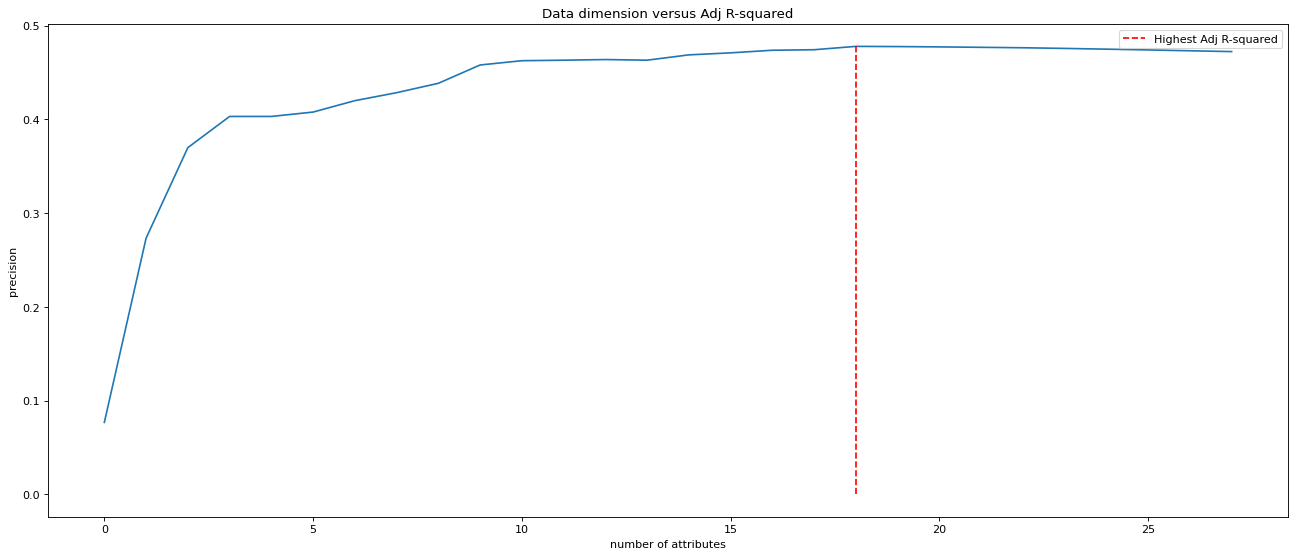

In [6]:
max_index = adj_r.index(max(adj_r))
plt.plot(adj_r)
plt.plot([max_index, max_index], [0, adj_r[max_index]], 'r--',label='Highest Adj R-squared')
plt.legend(loc='best')
plt.title('Data dimension versus Adj R-squared')
plt.xlabel('number of attributes')
plt.ylabel('precision')
plt.show()

<div style="background-color:#D9D9D9;"><font size="5"> Q2</font></div>

此處採用kaggle中關於Airbnb的開放式資料 https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata?resource=download <br><br>
(a.)首先預設我們想取得insight關於房型、地區、建造日期等對於其價格、評分、被觀看次數等之關聯。可以先把一些確定不會用到的欄位刪除。
<br>
資料集為3個月前發布，應是具有相當的時效性。若要取得更近期的資料Airbnb也有提供，是容易取得的。而此處資料多取自美國New York，對於其他地區是否有可參考性還需多評估。" `高度數據即時性、存取性，數據佔比性看分析面向` "

In [7]:
raw_data = pd.read_csv('Airbnb_Open_Data.csv')
print(raw_data.columns)
raw_data.head()

Index(['id', 'NAME', 'host id', 'host_identity_verified', 'host name',
       'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
       'country code', 'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'last review', 'reviews per month',
       'review rate number', 'calculated host listings count',
       'availability 365', 'house_rules', 'license'],
      dtype='object')


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [8]:
cols = [1,2,6,7,8,10,24]
df = raw_data.drop(raw_data.columns[cols], axis=1)
df.columns=[col.lower().replace(" ","_") for col in df.columns]
print(df.info())
#df2.describe()
percentage_result = df.isnull().sum()/df.shape[0] * 100

percentage_result = pd.DataFrame({"columns": percentage_result.keys(), "% missing": percentage_result})
percentage_result.reset_index(drop=True, inplace=True)
percentage_result

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   host_identity_verified          102310 non-null  object 
 2   host_name                       102193 non-null  object 
 3   neighbourhood_group             102570 non-null  object 
 4   country                         102067 non-null  object 
 5   instant_bookable                102494 non-null  object 
 6   cancellation_policy             102523 non-null  object 
 7   room_type                       102599 non-null  object 
 8   construction_year               102385 non-null  float64
 9   price                           102352 non-null  object 
 10  service_fee                     102326 non-null  object 
 11  minimum_nights                  102190 non-null  float64
 12  number_of_review

,columns,% missing
0,id,0.000000
1,host_identity_verified,0.281679
2,host_name,0.395715
3,neighbourhood_group,0.028265
4,country,0.518524
5,instant_bookable,0.102340
6,cancellation_policy,0.074075
7,room_type,0.000000
8,construction_year,0.208579
9,price,0.240743


<AxesSubplot: >

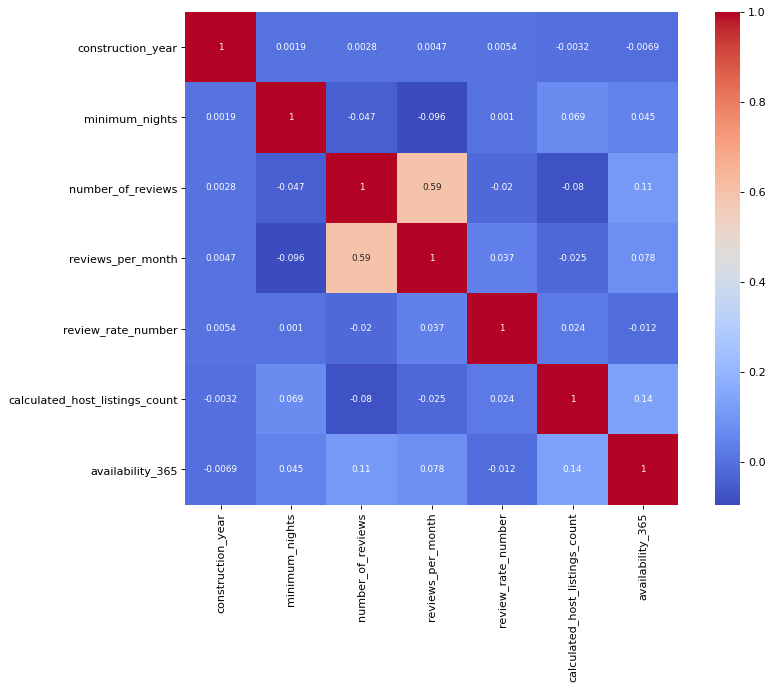

In [9]:
xnames = df.columns[[8,10,11,12,14,15,16,17]]
dfa = df[xnames].dropna()
corr1 = dfa.corr()
plt.figure(figsize=(12, 8)) # width and height in inches
sns.heatmap(corr1, cbar=1, square=1, annot=True, annot_kws={'size': 8}, cmap= 'coolwarm')

In [10]:
df.drop_duplicates(subset=['id'], keep='first', inplace=True) #刪除重複id

from IPython.core.display import HTML

#Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
def multi_table(table_list):
    return HTML('<table><tr style="background-color:white;">' +  ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +'</tr></table>')
            nunique_df={var:pd.DataFrame(df[var].value_counts().sort_index())
                for var in {'host_identity_verified', 'neighbourhood_group', 'instant_bookable',
                    'cancellation_policy','room_type','reviews_per_month',"review_rate_number","construction_year"}}

multi_table([nunique_df['host_identity_verified'],nunique_df['neighbourhood_group'],nunique_df['instant_bookable'],nunique_df['cancellation_policy'],nunique_df['room_type'],nunique_df['reviews_per_month'],nunique_df['review_rate_number'],nunique_df['construction_year']])

IndentationError: unexpected indent (1556726765.py, line 8)

以上驗證了`數據一致與格式`的部分，可以看到除了執照license嚴重缺乏（雖然不一定用到）外，只有最後一筆瀏覽last_review、每月被瀏覽次數reviews per month有稍微嚴重的資料缺少，其餘的null值小於1%。table中能看出每筆欄位中擁有的資料多是正常資料，無特異情形出現。id的部分也沒有缺漏，能作為primary key的部分去刪除重複值（刪除了500多筆資料，佔很小部分)<br>
數據準確度的部分也是無庸置疑，Airbnb為國際知名公司，且欄位元素多樣甚至包含經緯度能拿來精準劃分地區，適合進行深度分析。" `高數據準確度` "

In [ ]:
def remove_dollar_sign(value):
    if pd.isna(value):
        return np.NaN
    else:
        return float(value.replace("$","").replace(",","").replace(" ",""))
df['price'] = df['price'].apply(lambda x: remove_dollar_sign(x))
df['service_fee'] = df['service_fee'].apply(lambda x: remove_dollar_sign(x))

df["last_review"]=pd.to_datetime(df["last_review"])

In [ ]:
#https://www.kaggle.com/code/nguyenthicamlai/aribnb-preprocessing-eda/notebook
def plot_bar_chart(column_name: str, hue: str=None, top_values: int = None, palette: str = "flare", show_grid : bool = True, 
                   figsize: tuple = (16, 9), bar_font_size: int=14, bar_angle: int=45, angle: int=45):
    fig = plt.figure(facecolor = (247/255, 247/255, 247/255), figsize = figsize)
    ax = plt.subplot(1, 1, 1)
    
    ax.set_facecolor((247/255, 247/255, 247/255))
    counts = None
    
    if top_values is not None:
        counts = df[column_name].value_counts().iloc[:top_values]
    else:
        counts = df[column_name].value_counts()
        
    bar_ax = sns.barplot(x = counts.keys(), y = counts, palette = palette, ax = ax, hue = df[hue] if hue is not None else None) 
    
    for container in bar_ax.containers:
        bar_ax.bar_label(container, rotation=bar_angle, fontsize = bar_font_size)
        
    bar_ax.bar_label(bar_ax.containers[0], label_type='center', rotation=90, color='white')
        
    plt.xticks(rotation = angle, fontsize = 14)
    plt.xlabel(f"{column_name}", fontweight="bold", fontsize = 18)
    plt.ylabel("count", fontweight="bold", fontsize = 18)
    plt.title(f"Top {top_values} {column_name}" if top_values is not None else f"{column_name}", fontsize = 27)
    if show_grid: plt.grid()
    plt.show()


plot_bar_chart(column_name = "host_name", top_values = 30, palette = "icefire", show_grid = True, angle = 85)

In [ ]:
plt.figure(figsize=(5,3))
plt.title("Price and service fee", size=25, color="Navy")
sns.scatterplot(x=df.price, y=df.service_fee, hue=df.room_type, s=30);
#意外的部分是手續費和price完全正比

(b.) 資料品質確認SOP：
1. 確認數據一致、格式
    1. 檢查每個欄位有無錯誤資料類別，且符合上下界規範
    2. 有無重複的primary key，若重複應該如何處置
        1. 如使用者回傳資料時會不會因為網路延遲造成順序或反覆發送的錯誤
2. 確認機台取得的資料為全面性的，可靠正確的
    1. 機台有無故障？收集資料功能正常嗎？
    2. 是否有應收集而為收集之資料，可用魚骨圖表現，得滿足互無遺漏
    3. 是否有樣本間的多元變異性，能對決策議題呈現足夠與不同視角的資訊量
    4. 數據是否有可解釋性：相關聯的資料是否有合理的繪圖表現
3. 數據的來源與時效
    1. 時間線上新舊數據是否相容，若數據的年齡過久遠，是否依然能對此刻的分析產生效力
    2. 蒐集到的數據是否能夠對母體作出推論
    3. 數據是否時間相關或概念漂移。
          1. 同一特徵在相同(相似)樣本在不同時間點的機率分配是否一致
          2. 兩個以上的特徵間在不同時間下的相關性(如相關係數)是否一致。
4. 資訊安全
    1. 資訊來源是否正當，有沒有可能遭人詬病
    2. 是否會發生因組織內人為活動，所導致之數據品質問題
5. 建立人員採用資料的共同規範
    1. 在開發和設計資料庫和應用程序有統一且一致的參考模式
    2. 建立數據的量化評估準則
        1. 使數據有基礎品質
        2. 針對資料在不同指標的不足之處進行改善，循序漸進，使整體數據品質提升。
    3. 除了少數必須使用資料的人外，需要做適當的資訊屏蔽或是權限控管
        1. 如資料工程師得直接碰觸raw data，業務分析只能看到整理過的的資料圖表

(c.) 數據品質的量化指標：（假設有N筆資料，M個欄位）
1. 資料缺失率：
    1. 對所有包含數據分析會用到變數的欄位，若該筆資料(tuple)中有任意一缺失，註記該資料$n_i$為0其餘為1，<br>
        完整率為$\frac{1}{N} \sum_{k=1}^N n_i $，最高為1
2. 資料一致性：
    1. 令$ q_{ij} = 0 $ if 第 i 筆資料中的第 j 個欄位違反數據一致性（type不符合，超出範圍、新舊數據不相容)，其餘為1。<br>
        同時令$s_j$為認定此欄位的重要程度，where $j \in \{{1,...,M}$\}，$\sum_{j=1}^M s_j = 1$<br>
        評估資料的方式為：$\sum_{i=1}^N \sum_{j=1}^M q_{ij}*s_j$，最高為1
3. 資料時間有效性：
    1. 依照以往經驗，可得出此種類型的資料之有效保存期限，暫時設為 $T$<br>
        從此資料從機台被取出之時間到送至資料工程師之此時此刻的時間為 $t$<br>
        有效性則為 $1- \frac{t}{T}$ 越新鮮的資料越有效

<div style="background-color:#D9D9D9;"><font size="5"> Q3</font></div>

(a.) 什麼是模型的適應性與擴充性？<br>
數據會因為時間和空間有著不同的特性，而有著不同的分配。人們通常會傾向建構擁有良好適應性及擴充性的模型，使得此種分析架構在不同的時間空間，都能保持一定水準的預測力。<br>
`概念飄移：`對應的是時間。整個世界是不停在變動的，沒有模型能永遠持續下去。即使數據表現良好，模型本身也會開始退化。當模型train出的model不再適用，就可能發生概念飄移。此現象可快可慢，慢如世界的經濟成長VS信用貸款，快如疫情來襲時口罩飆高的銷售量。機器得到的數據沒變，世界卻變了，目標值的統計分配改變，得到的結果不再適用。<br>
`遷移學習：`對應空間。訓練出來的模型是否能夠對相同/類似領域的其他模型產生幫助。在欲訓練的目標模型測資缺乏時，能否透過類似的機台train出一個概括性的model，再用手邊少數的資料進行精準的加強

(b.) 我認為是具有高度適應性的，畢竟機台製造出的東西不會因為世界改變而改變，是純粹的造物。只是在機台不斷折舊損耗的情況下需要有個失真的標準去更新model。而擴充性的部分我覺得並沒有相當出色，廠商之間使用的製程工具可能有差距，不是說都能一體適用的，而且製造業講求精密，可能機台和機台間特殊的關聯不能被適用。但若是在同樣的廠商製造環境下應還是具有相當的參考性。

<div style="background-color:#D9D9D9;"><font size="5"> Q4</font></div>

(a.)<br>
`統計式填補`：如果是非numerical的資料遺失，大多數情況適合用眾數去填補。<br>
`預測式填補`：透過一些模型去生出遺漏值，可以讓整體的模型看起來fit的更好，且符合對心中圖像的預測。<br>
`生成式填補`：若是機率分佈於此份資料重要，可採用此方法去生成資料。

(b.)<br>
有時不能直接刪除含有大量遺漏值的特徵，會是因為該特徵與分析具有極大相關聯性，若刪除則可能使整份資料失去價值。應該要用上述各種填補方法，在資料之間找依據並互相填補。除此之外，遺失的資料可能是規律性的遺漏，那可能蘊含了某些背後的意涵可以去解讀，直接丟掉過於浪費。

<div style="background-color:#D9D9D9;"><font size="5"> Q5</font></div>

In [11]:
t1 = pd.read_excel('MDS_Assignment2_Steelplates.xlsx', sheet_name='Faults',header=None)
t2 = pd.read_excel('MDS_Assignment2_Steelplates.xlsx', sheet_name='Var_Name',header=None)
raw_data = t1.set_axis([i for i in t2[0]], axis=1, inplace=False)
raw_data

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,0.0206,0.5185,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254
1937,144,175,340581,340598,287,44,24,34599,112,133,...,0.0228,0.7046,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173
1938,145,174,386779,386794,292,40,22,37572,120,140,...,0.0213,0.7250,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079
1939,137,170,422497,422528,419,97,47,52715,117,140,...,0.0243,0.3402,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919


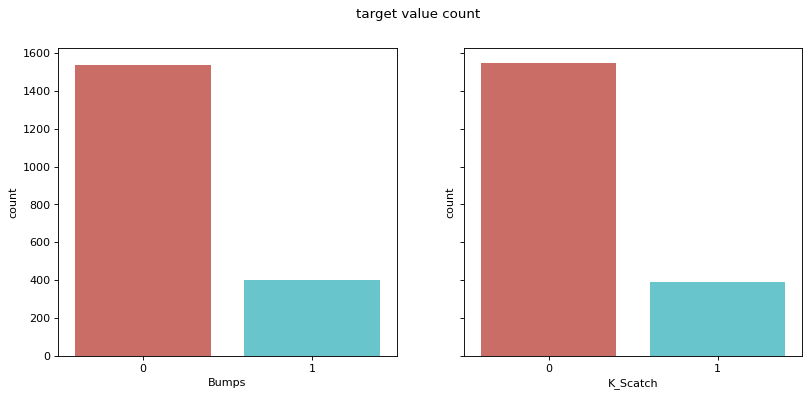

((1552, 27), (389, 27))

In [12]:
from sklearn.linear_model import LogisticRegression
#raw_data.isnull().sum() 沒有遺漏值
X = raw_data.iloc[:, :27]
display(X)
y1 = raw_data['Bumps']
y2 = raw_data['K_Scatch']

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('target value count')
sns.countplot(ax=axes[0], x='Bumps', data=raw_data, palette='hls')
sns.countplot(ax=axes[1], x='K_Scatch', data=raw_data, palette='hls')
plt.show()

from sklearn.model_selection import train_test_split #切割原始數據
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.2, random_state = 0)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size = 0.2, random_state = 0)
X1_train.shape, X1_test.shape

In [13]:
import statsmodels.api as sm
logit_model1=sm.Logit(y1_train,sm.add_constant(X1_train))
result1=logit_model1.fit()
print(result1.summary2())

logit_model2=sm.Logit(y2_train,sm.add_constant(X2_train))
result2=logit_model2.fit()
print(result2.summary2())

raw_data['Length_of_Conveyer'].mean()

Optimization terminated successfully.
         Current function value: 0.352595
         Iterations 16
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.308     
Dependent Variable:    Bumps              AIC:                1148.4534 
Date:                  2022-11-03 21:44   BIC:                1292.8305 
No. Observations:      1552               Log-Likelihood:     -547.23   
Df Model:              26                 LL-Null:            -791.09   
Df Residuals:          1525               LLR p-value:        1.1932e-86
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        16.0000                                          
------------------------------------------------------------------------
                       Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------------
const                 -16.6630      nan     nan   

1459.1602266872746

(1.) 在測試集中可以看到Length_of_Conveyer輸送帶長度，平均值為1459單位，而在上方兩模型中，輸送帶每增加一單位，凹凸不平(Bump)的coef為0.0016，代表是有Bump勝算的1.0016倍，而刮痕(K_Scatch)中係數為-0.0066，代表會因為每一單位，勝算都為原本的0.9934倍（勝算離1越遠越顯著）
<br><br>(2.) 以下為顯著結果：（p-value<0.01)

In [14]:
#Bumps
tmp1 = result1.tvalues[1:].sort_values(key=lambda x:abs(x), ascending=False).dropna()
tmp1[:11]

Y_Minimum                4.871026
Y_Maximum               -4.871021
Edges_Y_Index            4.486331
Edges_Index              4.255855
Y_Perimeter              4.217826
Square_Index             3.731378
Luminosity_Index        -3.662027
Maximum_of_Luminosity    3.395047
Steel_Plate_Thickness   -3.322124
X_Perimeter             -3.246499
Minimum_of_Luminosity    2.661779
dtype: float64

In [15]:
#K_scatch
tmp2 = result2.tvalues[1:].sort_values(key=lambda x:abs(x), ascending=False).dropna()
tmp2[:3]

Orientation_Index   -3.561947
Edges_X_Index        3.402593
X_Perimeter          2.736891
dtype: float64

### (3.) 羅吉斯回歸
Logistic regression在預測兩者模型的p-value都能代表是個有效的模型，個別的比較上會是在K_scatch上表現更好，Adj Rsquared較大，AIC,BIC小。可能相較於Bumps更適合用logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [17]:
logreg = LogisticRegression()
#訓練組預測
logreg.fit(X1_train, y1_train)
y_pred_test1_ori = logreg.predict(X1_train)

logreg.fit(X2_train, y2_train)
y_pred_test2_ori = logreg.predict(X2_train)

#測試組
logreg.fit(X1_train, y1_train)
y_pred_test1 = logreg.predict(X1_test)

logreg.fit(X2_train, y2_train)
y_pred_test2 = logreg.predict(X2_test)

In [18]:
#特徵縮放(Feature Scaling)
cols = X1_train.columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)
X1_train = pd.DataFrame(X1_train, columns=[cols])
X1_test = pd.DataFrame(X1_test, columns=[cols])
#display(X1_train.describe())

X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)
X2_train = pd.DataFrame(X2_train, columns=[cols])
X2_test = pd.DataFrame(X2_test, columns=[cols])
X2_train.describe()
#y的index要對齊
y1_train.reset_index(drop=True, inplace=True)
y1_train = pd.DataFrame(y1_train, columns=['Bumps'])
y2_train.reset_index(drop=True, inplace=True)
y2_train = pd.DataFrame(y2_train, columns=['K_Scatch'])

In [19]:
#縮放後測試
logreg.fit(X1_train, y1_train)
y_pred_test1_scaled = logreg.predict(X1_test)
y_pred_test1_scaled

logreg.fit(X2_train, y2_train)
y_pred_test2_scaled = logreg.predict(X2_test)
y_pred_test2_scaled

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,

In [20]:
print('Model accuracy score origin: {0:0.4f}'. format(accuracy_score(y1_train, y_pred_test1_ori)))
print('Model accuracy score origin: {0:0.4f}'. format(accuracy_score(y2_train, y_pred_test2_ori)))
print()
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y1_test, y_pred_test1)))
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y2_test, y_pred_test2)))
print()
print('Model accuracy score after scaled: {0:0.4f}'. format(accuracy_score(y1_test, y_pred_test1_scaled)))
print('Model accuracy score after scaled: {0:0.4f}'. format(accuracy_score(y2_test, y_pred_test2_scaled)))
print()
print("訓練集的預測準確度確實有小幅度的較高，但範圍甚小--->there is no question of overfitting.")
print("可以得知經過特徵縮放以後，模型的預測準確度有提升，減少了某些過大變數帶來的影響")

Model accuracy score origin: 0.7874
Model accuracy score origin: 0.9491

Model accuracy score: 0.7866
Model accuracy score: 0.9434

Model accuracy score after scaled: 0.8123
Model accuracy score after scaled: 0.9717

訓練集的預測準確度確實有小幅度的較高，但範圍甚小--->there is no question of overfitting.
可以得知經過特徵縮放以後，模型的預測準確度有提升，減少了某些過大變數帶來的影響


可以知道Bumps的表現較差是fn過多


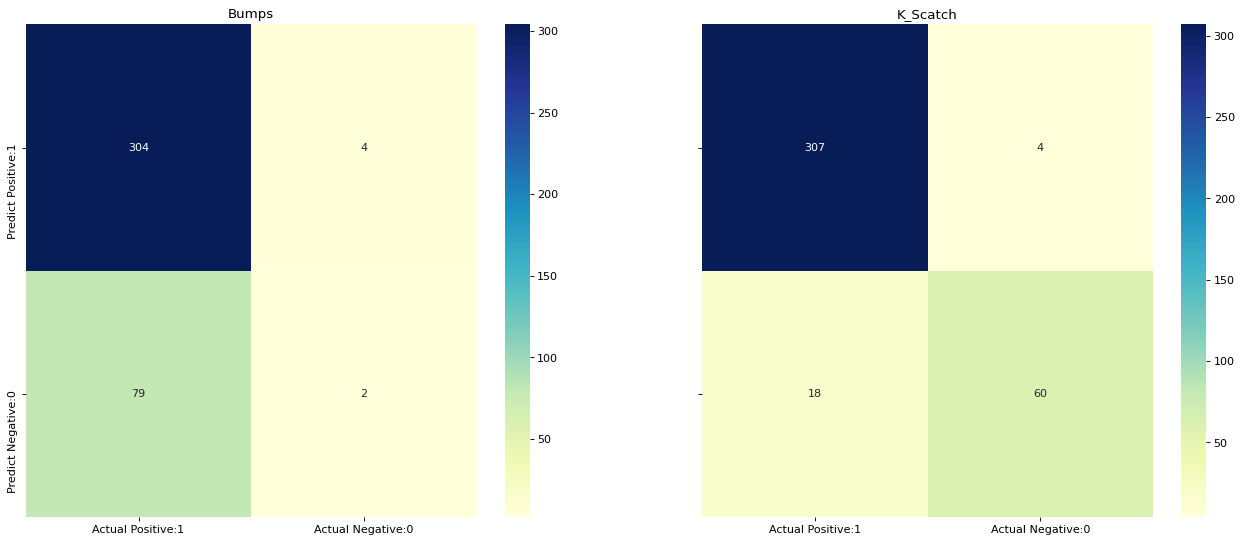

In [21]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y1_test, y_pred_test1)
cm_matrix1 = pd.DataFrame(data=cm1, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
cm2 = confusion_matrix(y2_test, y_pred_test2)
cm_matrix2 = pd.DataFrame(data=cm2, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True)
sns.heatmap(cm_matrix1, annot=True, fmt='d', cmap='YlGnBu', ax=ax1)
sns.heatmap(cm_matrix2, annot=True, fmt='d', cmap='YlGnBu', ax=ax2)

ax1.title.set_text('Bumps')
ax2.title.set_text('K_Scatch')

print("可以知道Bumps的表現較差是fn過多")
#https://gist.github.com/pb111/62067d128be7f7f86e81916ff946af7b

### (4.) 線性判別分析模型

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [23]:
model = LDA()
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
cm = confusion_matrix(y1_test, y1_pred)
print(cm)
print('Bumps Accuracy' + str(accuracy_score(y1_test, y1_pred)))

model.fit(X2_train, y2_train)
y2_pred = model.predict(X2_test)
cm = confusion_matrix(y2_test, y2_pred)
print(cm)
print('K_Scatch Accuracy' + str(accuracy_score(y2_test, y2_pred)))

[[277  31]
 [ 48  33]]
Bumps Accuracy0.7969151670951157
[[308   3]
 [ 15  63]]
K_Scatch Accuracy0.9537275064267352


可以看到簡單的線性判別模型，對於兩缺陷的預測還要高於使用羅吉斯回歸，且準確率相當高，都大於0.75

### (5.)二次判別分析模型

In [24]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qd = qda.fit(X1_train,y1_train).predict(X1_test)
print('Bumps Accuracy：',str(round(qda.score(X1_test,y1_test),2)))

qd = qda.fit(X2_train,y2_train).predict(X2_test)
print('K_Scatch Accuracy：',str(round(qda.score(X2_test,y2_test),2)))

Bumps Accuracy： 0.6
K_Scatch Accuracy： 0.95


Bumps Accuracy在此的正確率是三個模型中最低的。可能有過度配適的問題。